<a href="https://www.kaggle.com/code/mahendrasinghrajpoot/olid-dataset?scriptVersionId=127696531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("/kaggle/input/olid-tweet-dataset/train.csv")
test = pd.read_csv("/kaggle/input/olid-tweet-dataset/test.csv")
val = pd.read_csv("/kaggle/input/olid-tweet-dataset/valid.csv")

In [3]:
data = [train,test,val]

for i in data:
  print(i.shape)

(12313, 3)
(860, 3)
(927, 3)


In [4]:
train.head()

,id,tweet,label
0,42884,@USER I’m done with you as well. An INTENTIONA...,NOT
1,92152,I now have over 6k followers. Only 94k to go ...,NOT
2,65475,@USER Tom was bought! He is more interested in...,NOT
3,22144,@USER @USER Even her brother thinks she is a m...,OFF
4,81048,@USER @USER @USER @USER @USER I can understand...,OFF


In [5]:
X_train = train['tweet']
y_train = train['label']
X_test = test['tweet']
y_test = test['label']
X_val = val['tweet']
y_val = val['label']


In [6]:
y_train = y_train.replace({"NOT":0,"OFF":1})

In [7]:
y_val = y_val.replace({"NOT":0,"OFF":1})
y_test = y_test.replace({"NOT":0,"OFF":1})

In [8]:
for i in data:
  print(i.label.value_counts())

NOT    8221
OFF    4092
Name: label, dtype: int64
NOT    620
OFF    240
Name: label, dtype: int64
NOT    619
OFF    308
Name: label, dtype: int64


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert the text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them equal in length
max_len = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define the RNN encoder-decoder model
latent_dim = 50

# Encoder
encoder_inputs = Input(shape=(max_len,))
enc_emb = Embedding(5000, 64, input_length=max_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len,))
dec_emb_layer = Embedding(5000, 64, input_length=max_len)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(1, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train_padded,X_train_padded], y_train, epochs=10, batch_size=32, validation_data=([X_test_padded,X_test_padded], y_test))

Epoch 1/10
385/385 [==============================] - 43s 90ms/step - loss: 0.6283 - accuracy: 0.6726 - val_loss: 0.5580 - val_accuracy: 0.7494
Epoch 2/10
385/385 [==============================] - 10s 26ms/step - loss: 0.5121 - accuracy: 0.7727 - val_loss: 0.4745 - val_accuracy: 0.8048
Epoch 3/10
385/385 [==============================] - 8s 22ms/step - loss: 0.4660 - accuracy: 0.8071 - val_loss: 0.5056 - val_accuracy: 0.7709
Epoch 4/10
385/385 [==============================] - 8s 22ms/step - loss: 0.4656 - accuracy: 0.8065 - val_loss: 0.5075 - val_accuracy: 0.7807
Epoch 5/10
385/385 [==============================] - 7s 19ms/step - loss: 0.4552 - accuracy: 0.8149 - val_loss: 0.4951 - val_accuracy: 0.7955
Epoch 6/10
385/385 [==============================] - 6s 16ms/step - loss: 0.4222 - accuracy: 0.8340 - val_loss: 0.4850 - val_accuracy: 0.7782
Epoch 7/10
385/385 [==============================] - 6s 15ms/step - loss: 0.4035 - accuracy: 0.8398 - val_loss: 0.5118 - val_accuracy: 0.77

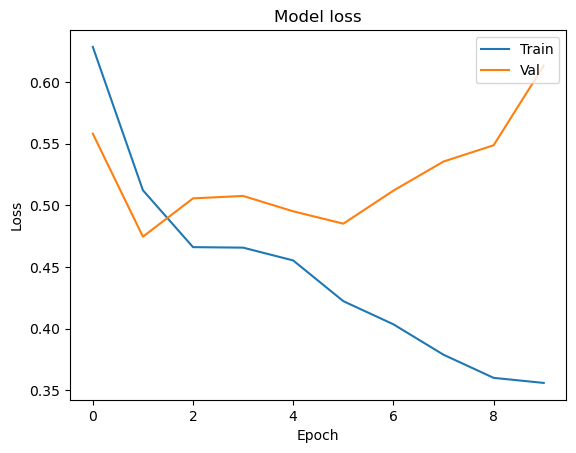

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


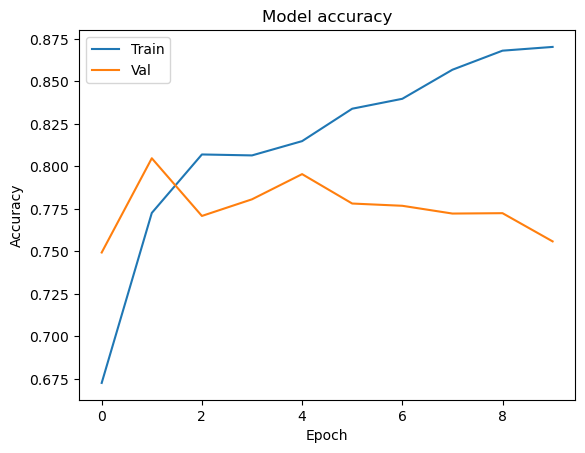

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
